# 电商网站欺诈监测
## 作者 ：于沛
### 1. 你选择了什么模型?为什么选择这个模型?

<ul>
<li>我选择了逻辑回归模型；</li>
<li>因为欺诈问题其实是二元分类问题，欺诈与非欺诈；</li>
</ul>

### 2. 如何衡量你模型的效果?给出⼀些衡量量指标。

<ul>
<li>我通过使用混淆矩阵对模型进行评估，准确率97%；</li>
</ul>

### 3. 不同的false positive cost ÷ false negative cost会如何影响你对模型的处理?

<ul>
<li>通过准确率，精确率,召回率对模型进行评估，可先通过适当降低准确率来提高召回率；</li>
</ul>

### 4. 如果给你更多的时间，你会从哪些方面优化你的模型?

<ul>
<li>首先会增加注册到购买的时间差这个属性，并对其进行特征的验证；</li>
<li>其次，对于样本不平衡问题，尝试其他解决方案，并观察结果；</li>
</ul> 

### 5. 从⽤户⻆度去解释:什么样的⽤户会被判断为欺诈?这些用户有什什么特征?

通过分析我们可以看出：
<ul>
<li>欺诈用户购买金额大都集中在小额和中等额度购买上，与普通顾客的购买行为十分相似；</li>
<li>从来源上来看，直接点击进来购买的顾客中欺诈用户最少；</li>
<li>从浏览器来看，使用opera浏览器的用户最少，不具有鲜明的可比性。相对来说，Chrome浏览器用户有最高的诈骗比例；</li>
<li>从性别上来看，女性用户诈骗比例相对于男性较少；</li>
</ul> 

### 6. 基于这个模型，现在你有了⼀个可以实时预测⽤户⾏为是否为欺诈的系统，你将如何将这套系统融合到现有的产品中?也就是说，该系统应该在整体交易易流程的什么环节发挥作⽤?对⽤户行为做出预测之后，交易易流程该如何继续?
<ul>
<li>可以将现有产品融入客户系统中，并对每一个用户的初始数据进行评估打分;</li>
<li>在客户准备下单购买时，再对客户现有情况进行打分，如果分数低于标准值，则在付款之前加入验证系统（手机号，邮箱验证）；</li>
<li>若用户打分低于危险值，则可以进行拒绝支付并请客户联系银行进行验证付款；</li>
</ul> 
    


In [1]:
%matplotlib inline
from collections import Counter
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from scipy.stats import multivariate_normal
import statsmodels.api as sm
from sklearn import linear_model
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import warnings
warnings.filterwarnings('ignore')
from sklearn.linear_model import LogisticRegression
from datetime import datetime

/Users/yupei/anaconda2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
Fraud_Data = pd.read_csv('Fraud_Data.csv')

#### dataset详情

In [3]:
Fraud_Data.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,151112.0,2.001710e+05,1.153693e+05,2.00000,1.006425e+05,1.999580e+05,3.000540e+05,4.000000e+05
purchase_value,151112.0,3.693537e+01,1.832276e+01,9.00000,2.200000e+01,3.500000e+01,4.900000e+01,1.540000e+02
age,151112.0,3.314070e+01,8.617733e+00,18.00000,2.700000e+01,3.300000e+01,3.900000e+01,7.600000e+01
ip_address,151112.0,2.152145e+09,1.248497e+09,52093.49689,1.085934e+09,2.154770e+09,3.243258e+09,4.294850e+09
class,151112.0,9.364577e-02,2.913362e-01,0.00000,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
device_id_num,151112.0,1.007665e+03,2.696376e+01,901.00000,9.890000e+02,1.008000e+03,1.026000e+03,1.119000e+03


#### 查看欺诈比例

In [4]:
Fraud_Data['class'].value_counts()

0    136961
1     14151
Name: class, dtype: int64

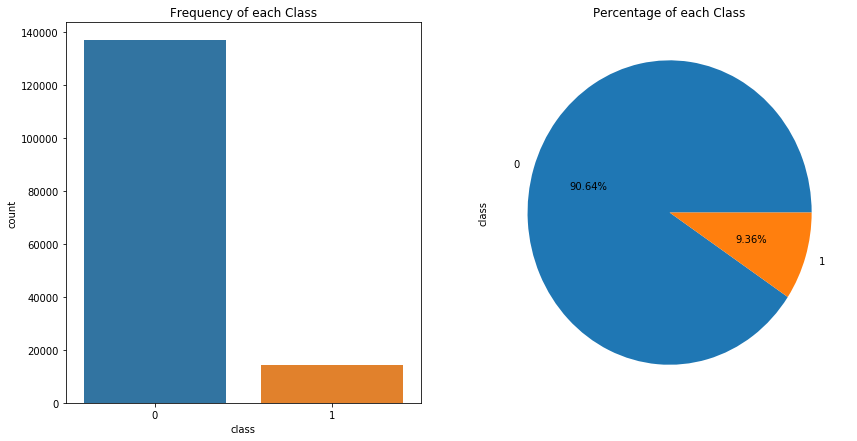

In [5]:
fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='class',data=Fraud_Data,ax=axs[0])
axs[0].set_title("Frequency of each Class")
Fraud_Data['class'].value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Class")
plt.show()

#### 从上图可以看出，在样本中分布很不平均，欺诈用户数据相对于总体数据的1/10，根据这种情况，我会在后面会进行欠采样，以保证数据的样本平衡。

#### 将source，browser，sex编码化

In [6]:
def source_encoding(x):
    if(x=='SEO'):
        x='1'
    elif(x=='Ads'):
        x='2'
    elif(x=='Direct'):
        x='3'
    return x

In [7]:
def browser_encoding(x):
    if(x=='Chrome'):
        x='1'
    elif(x=='Opera'):
        x='2'
    elif(x=='Safari'):
        x='3'
    elif(x=='FireFox'):
        x='4'
    elif(x=='IE'):
        x='5'
    return x

In [8]:
def sex_encoding(x):
    if(x=='M'):
        x='1'
    elif(x=='F'):
        x='2'
    return x

In [9]:
Fraud_Data['source']=Fraud_Data['source'].apply(source_encoding)
Fraud_Data['browser']=Fraud_Data['browser'].apply(browser_encoding)
Fraud_Data['sex']=Fraud_Data['sex'].apply(sex_encoding)

In [10]:
Fraud_Data['source']=Fraud_Data['source'].apply(lambda x:int(x))
Fraud_Data['browser']=Fraud_Data['browser'].apply(lambda x:int(x))
Fraud_Data['sex']=Fraud_Data['sex'].apply(lambda x:int(x))

In [11]:
Fraud_Data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null int64
browser           151112 non-null int64
sex               151112 non-null int64
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
device_id_num     151112 non-null int64
dtypes: float64(1), int64(8), object(3)
memory usage: 13.8+ MB


#### 查看欺诈与各属性之间关系

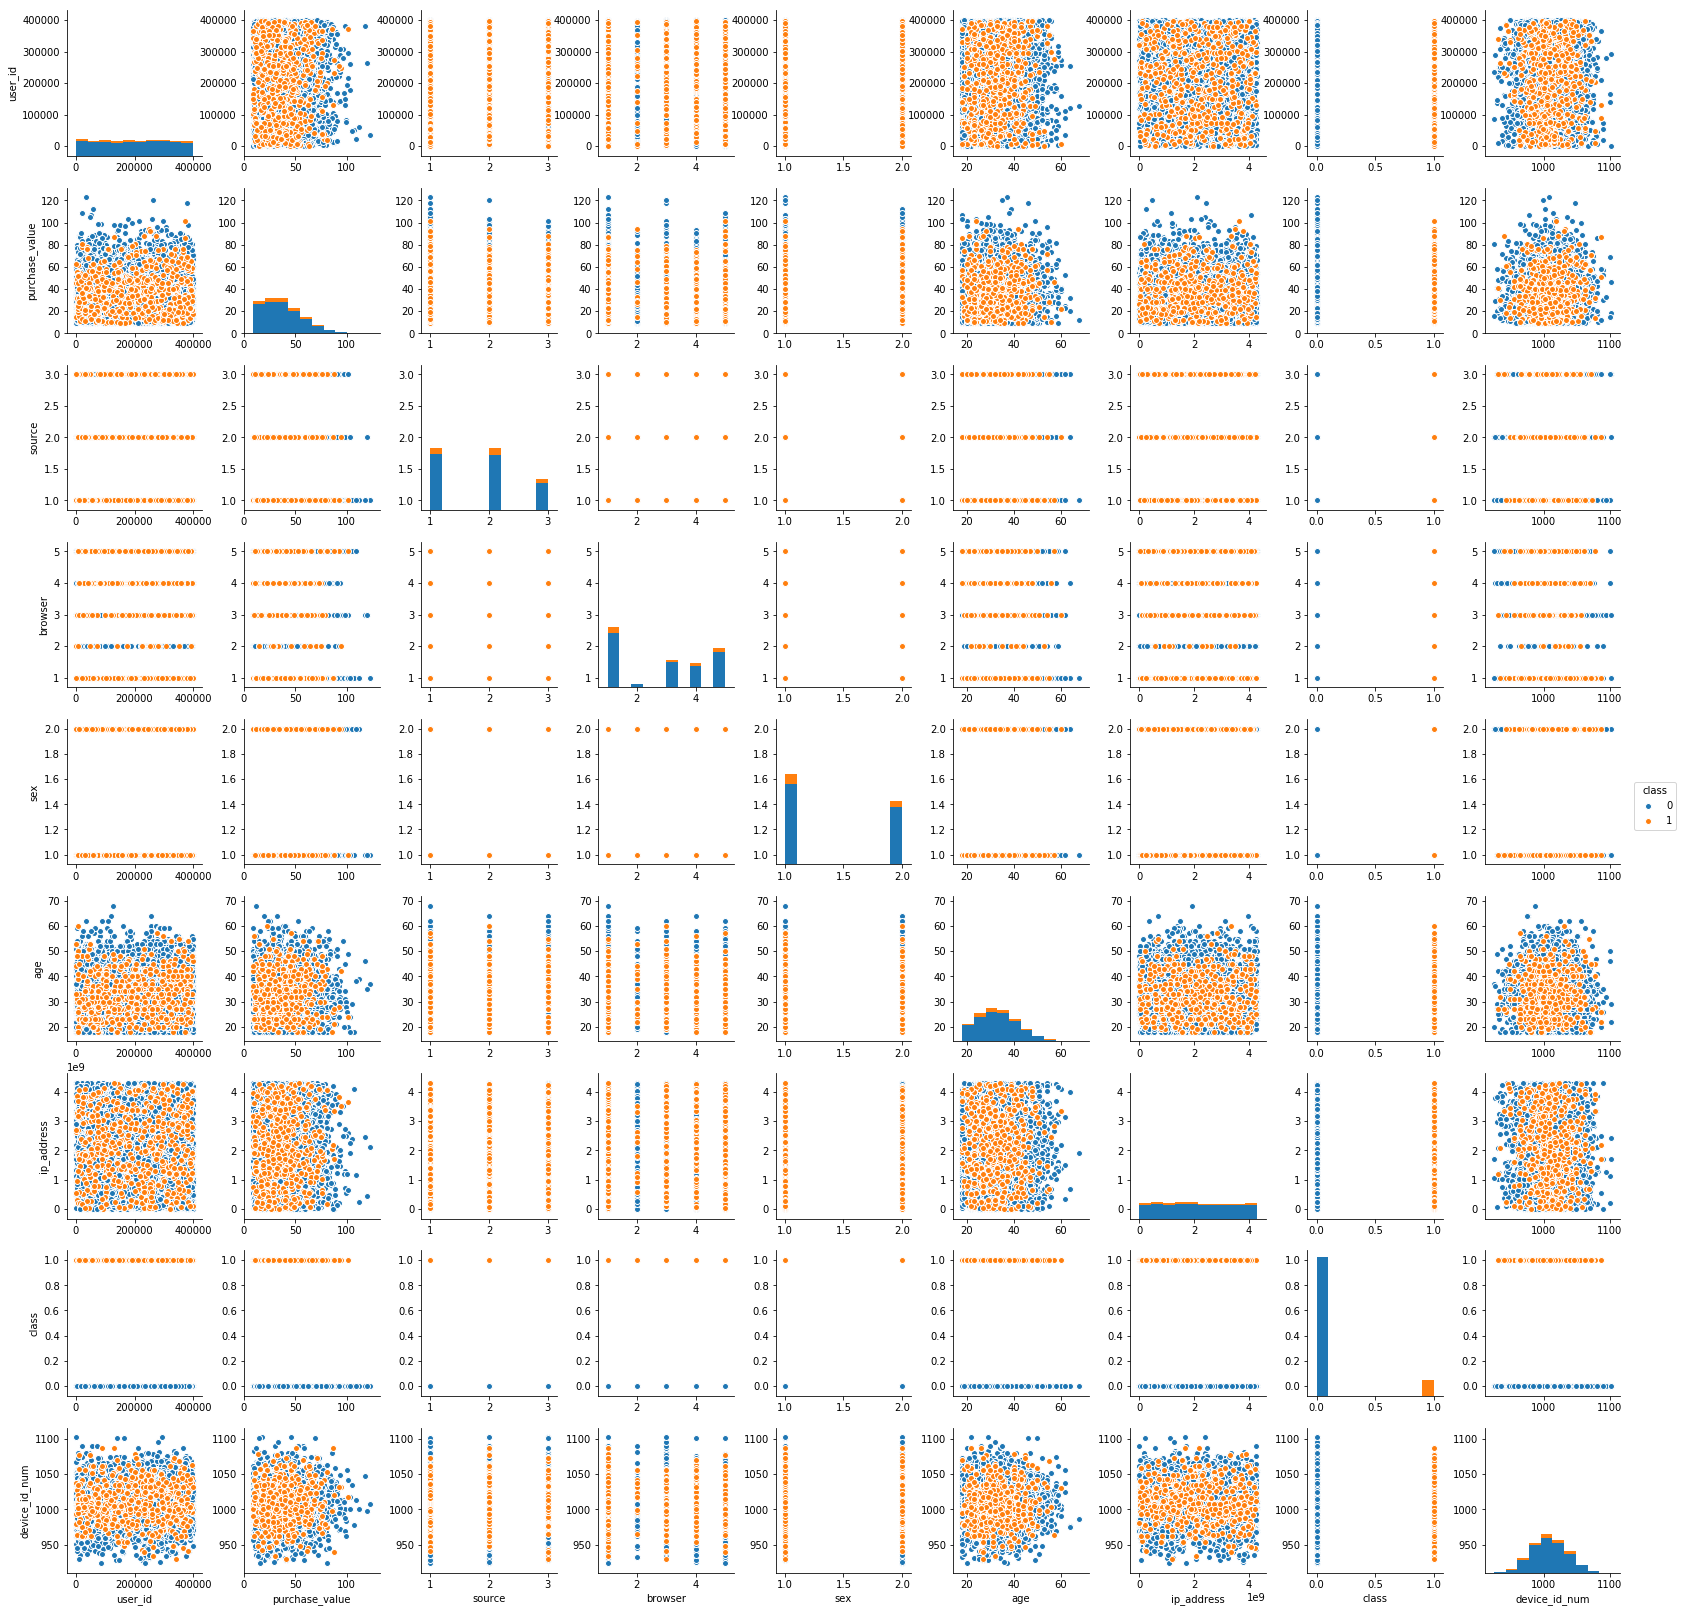

In [12]:
sns.pairplot(Fraud_Data[:5000], hue="class")

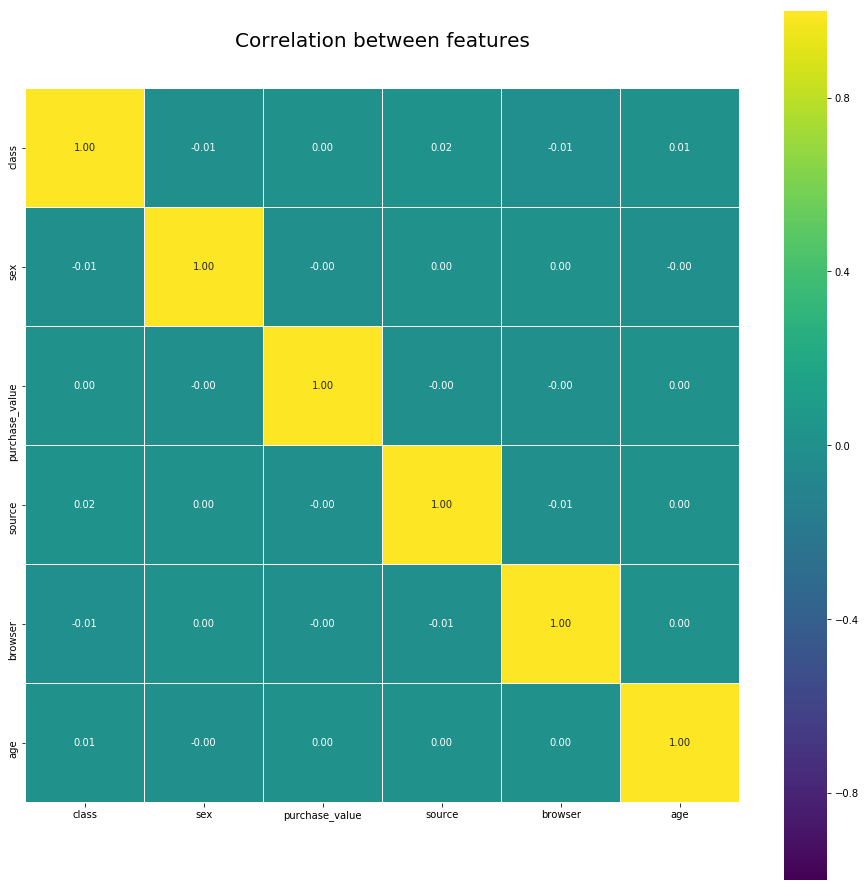

In [13]:
num_features = ['class','sex','purchase_value','source','browser','age']
test = Fraud_Data[num_features]
colormap = plt.cm.viridis
plt.figure(figsize = (16,16))
plt.title('Correlation between features', y=1.05, size = 20)
sns.heatmap(test.corr(),
            linewidths=0.1, 
            center = 0,
            vmin = -1,
            vmax = 1, 
            annot = True,
            square = True, 
            fmt ='.2f', 
            annot_kws = {'size': 10},
            cmap = colormap, 
            linecolor ='white');

#### 增加一列，将购买日期转换为购买的当日时间

In [14]:
import time, datetime
def change_date_to_hour(x):
    tss3 = x
    timeArray = time.strptime(tss3, "%Y/%m/%d %H:%M")
    x = time.strftime("%H", timeArray)
    return x;

In [15]:
Fraud_Data['purchase_time_hour']=Fraud_Data['purchase_time'].apply(change_date_to_hour)

#### 查看消费金额在欺诈与正常订单中的分布

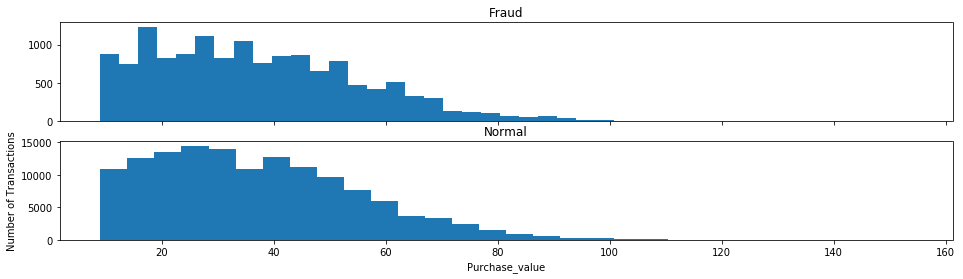

In [16]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,4))
bins = 30

ax1.hist(Fraud_Data["purchase_value"][Fraud_Data["class"]== 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(Fraud_Data["purchase_value"][Fraud_Data["class"]== 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Purchase_value')
plt.ylabel('Number of Transactions')
plt.show()

#### 查看每日消费情况在时间中的分布

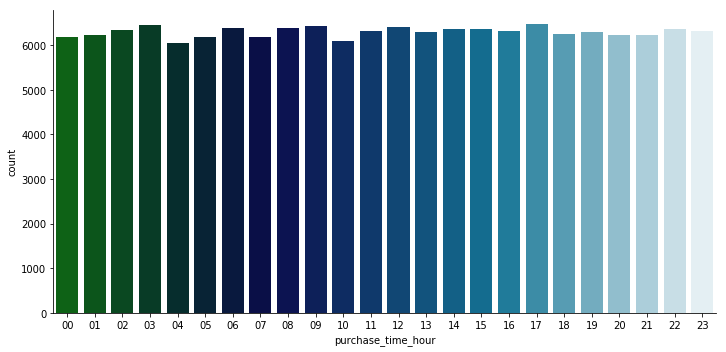

In [17]:
sns.factorplot(x="purchase_time_hour", data=Fraud_Data, kind="count",  palette="ocean", size=5, aspect=2)

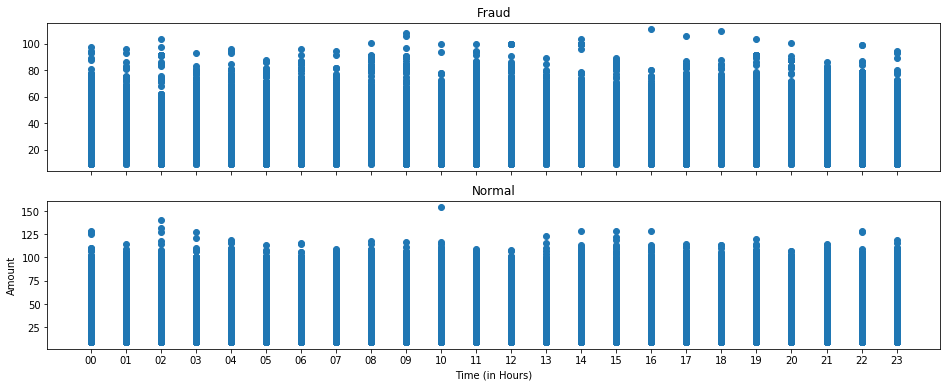

In [18]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(16,6))

ax1.scatter(Fraud_Data["purchase_time_hour"][Fraud_Data["class"] == 1], Fraud_Data["purchase_value"][Fraud_Data["class"]  == 1])
ax1.set_title('Fraud')

ax2.scatter(Fraud_Data["purchase_time_hour"][Fraud_Data["class"] == 0], Fraud_Data["purchase_value"][Fraud_Data["class"] == 0])
ax2.set_title('Normal')

plt.xlabel('Time (in Hours)')
plt.ylabel('Amount')
plt.show()

In [19]:
Fraud_Data=Fraud_Data.drop('signup_time',1)
Fraud_Data=Fraud_Data.drop('purchase_time',1)

#### 对device_id进行编码化处理

In [20]:
def device_id_trans_num(x):
    array_1 = x.split()
    length = len(array_1[0])
    array_num1=0;
    for i in range(0,length):
        array_num1 = str(ord(array_1[0][i]))+str(array_num1)
    return array_num1

In [21]:
test_2 = []
for i in range(0,151112):
    test_2.append(device_id_trans_num(Fraud_Data['device_id'][i]))

In [22]:
test_3 = pd.DataFrame(test_2)
test_3.to_csv('test1.csv', index=None)
Fraud_Data=Fraud_Data.drop('device_id',1)

In [23]:
type(Fraud_Data)

pandas.core.frame.DataFrame

In [24]:
Fraud_Data.insert(7,'device_id',test_3[0])

In [25]:
Fraud_Data['purchase_time_hour']=Fraud_Data['purchase_time_hour'].apply(lambda x:int(x))

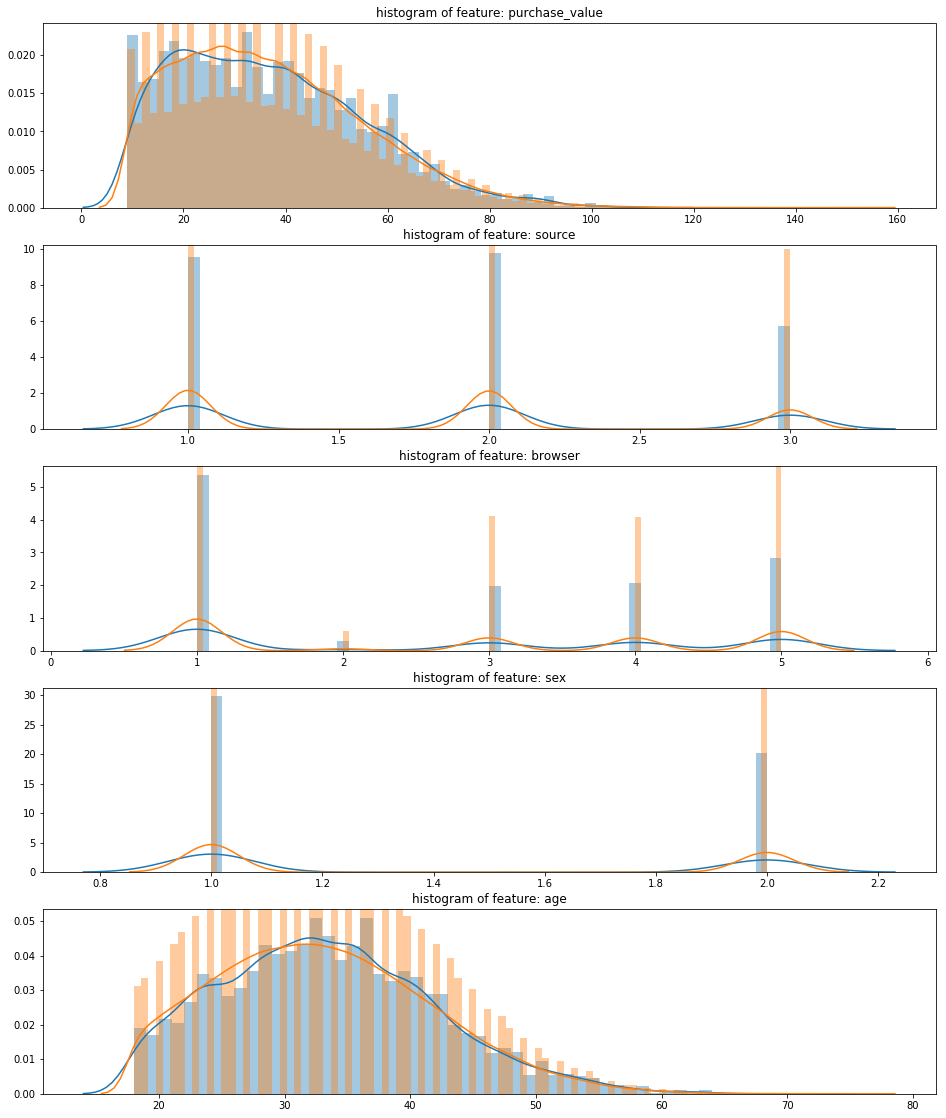

In [26]:
import matplotlib.gridspec as gridspec
v_feat = Fraud_Data.ix[:,1:6].columns
plt.figure(figsize=(16,9*4))
gs = gridspec.GridSpec(9, 1)
for i, cn in enumerate(Fraud_Data[v_feat]):
    ax = plt.subplot(gs[i])
    sns.distplot(Fraud_Data[cn][Fraud_Data["class"] == 1], bins=50)
    sns.distplot(Fraud_Data[cn][Fraud_Data["class"] == 0], bins=100)
    ax.set_xlabel('')
    ax.set_title('histogram of feature: ' + str(cn))

In [27]:
ip_Data = pd.read_csv('IpAddress_to_Country.csv')

#### 对于每个⽤用户，根据IP映射表找出对应的国家。以下为方法：

In [28]:
def get_ip_value(x):
    for i in range(0,138845):
         if ip_Data['lower_bound_ip_address'][i]<x and x<ip_Data['upper_bound_ip_address'][i]:
                x=ip_Data['country'][i]
    return x

In [29]:
# test_ip = Fraud_Data['ip_address']

#### 因目前写的方法将ip替换为国家效率太低，需要大量时间进行查找替换。故暂去除ip地址这一属性（但此属性十分重要，若有时间需要进行ip替换处理并按国家属性进行分析）

In [30]:
Fraud_Data=Fraud_Data.drop('ip_address',1)
Fraud_Data=Fraud_Data.drop('device_id_num',1)

####  对以下的属性进行标准化

In [31]:
col = ['purchase_value','age','purchase_time_hour']
from sklearn.preprocessing import StandardScaler 
sc =StandardScaler() 
Fraud_Data[col] =sc.fit_transform(Fraud_Data[col])
Fraud_Data.head()

,user_id,purchase_value,source,browser,sex,age,device_id,class,purchase_time_hour
0,22058,-0.160204,1,1,1,0.679914,826590756779857480838086810,0,-1.377455
1,333320,-1.142592,2,1,2,2.304476,907088898090738081707179690,0,-1.522122
2,1359,-1.197169,1,2,1,2.304476,747680807274837989758383890,1,0.937208
3,150084,0.385567,1,3,1,0.911994,788185688575897588847184650,0,0.213876
4,221365,0.112681,2,3,1,1.376155,878772757470906684738565780,0,0.937208


#### 对现有数据集中的正样本进行抽取，组成新的数据集

In [32]:
Fraud_Data_1=Fraud_Data[Fraud_Data["class"]==1]
Fraud_Data_1.count()

user_id               14151
purchase_value        14151
source                14151
browser               14151
sex                   14151
age                   14151
device_id             14151
class                 14151
purchase_time_hour    14151
dtype: int64

In [33]:
Fraud_Data_0=Fraud_Data[Fraud_Data["class"]==0]

In [34]:
Fraud_Data_0finish=Fraud_Data_0.sample(n=14151, frac=None, replace=False, weights=None, random_state=None, axis=None)

In [35]:
Fraud_Data_0finish.count()

user_id               14151
purchase_value        14151
source                14151
browser               14151
sex                   14151
age                   14151
device_id             14151
class                 14151
purchase_time_hour    14151
dtype: int64

In [36]:
new_Fraud_Data=Fraud_Data_0finish.append(Fraud_Data_1)
new_Fraud_Data

,user_id,purchase_value,source,browser,sex,age,device_id,class,purchase_time_hour
87967,213695,-0.378513,1,3,2,0.215753,777281868877796887817665700,0,-0.220124
98993,337692,0.658452,2,3,1,-0.248408,696689837072858283826970800,0,-1.377455
89283,132978,-0.651398,2,4,2,-1.408809,657684908768657473707066770,0,-0.943456
37064,15531,-0.214781,3,1,1,0.215753,718068696567698971798881830,0,0.937208
18788,196279,1.804572,3,5,1,-0.828608,767779728873807275738670790,0,-1.522122
52187,245033,-0.705975,2,3,1,-0.016327,728875887081907886738773790,0,-1.232789
85545,347923,0.003527,3,4,1,-1.176729,777467747283838374848589880,0,1.515874
123436,350913,-1.197169,1,2,2,0.795954,748989836687877283818475900,0,-0.075457
89594,94905,-0.105627,3,1,1,-1.176729,828572767876707876779070760,0,0.792542
75035,263317,0.385567,1,4,1,0.215753,856878837074718972797287690,0,-1.377455


In [37]:
new_Fraud_Data=new_Fraud_Data.sample(frac=1).reset_index(drop=True) 
new_Fraud_Data

,user_id,purchase_value,source,browser,sex,age,device_id,class,purchase_time_hour
0,65752,0.167258,2,5,1,-0.596528,718483786874747174768173880,0,0.503209
1,105450,-0.487667,2,1,1,-0.248408,707289838668836978747376850,1,-1.232789
2,251333,-0.978861,1,5,1,0.679914,778166757976857872828173890,0,1.371208
3,111374,0.440144,3,5,1,2.768637,887290746788667878806889660,1,0.647875
4,175659,0.167258,3,5,2,0.215753,857876688772716584718274660,0,0.937208
5,219467,0.167258,3,3,1,-0.132367,758971708865778468668990650,1,1.515874
6,130414,-0.815129,1,1,2,0.215753,767974738767658269846789720,0,-1.232789
7,26481,0.658452,1,1,1,0.795954,758765839088796790839089780,1,0.647875
8,228325,-0.378513,1,5,2,-0.596528,686572717588677366797371900,0,1.660541
9,322697,0.876761,2,5,2,1.376155,746576867770668366867372660,0,1.226541


In [38]:
x_feature = list(new_Fraud_Data.columns)
x_feature.remove('class')
x_val = new_Fraud_Data[x_feature]
y_val = new_Fraud_Data['class']

In [39]:
names = new_Fraud_Data[x_feature].columns
from sklearn.ensemble import RandomForestClassifier
clf=RandomForestClassifier(n_estimators=10,random_state=123)
clf.fit(x_val, y_val) 
names, clf.feature_importances_
for feature in zip(names, clf.feature_importances_):
    print(feature)

('user_id', 0.17267873637720837)
('purchase_value', 0.19323091159113776)
('source', 0.03287459663768471)
('browser', 0.040989102532192366)
('sex', 0.01776101766943191)
('age', 0.1566972713359108)
('device_id', 0.23848928140661774)
('purchase_time_hour', 0.14727908244981633)


(-1, 8)

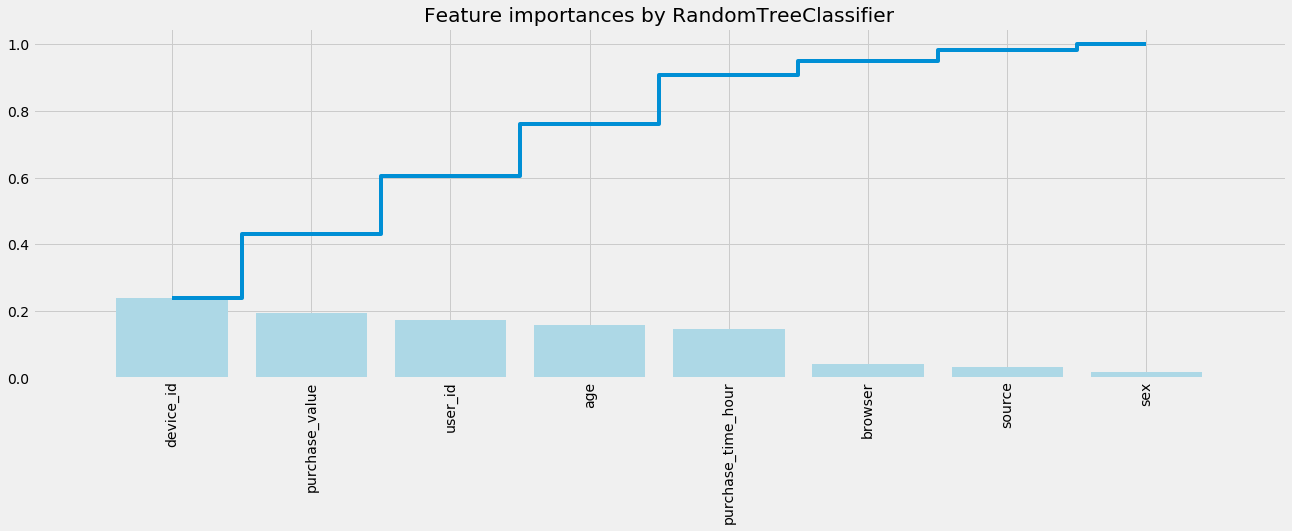

In [40]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12,6)

## feature importances 可视化##
importances = clf.feature_importances_
feat_names = names
indices = np.argsort(importances)[::-1]
fig = plt.figure(figsize=(20,6))
plt.title("Feature importances by RandomTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])

#### 由于样本中，欺诈与非欺诈比例不平衡，所以进行采样处理

In [41]:
X = new_Fraud_Data[x_feature]
y = new_Fraud_Data["class"]

n_sample = float(y.shape[0])
n_pos_sample = y[y == 0].shape[0]
n_neg_sample = y[y == 1].shape[0]
print('样本个数：{}; 正样本占{:.2%}; 负样本占{:.2%}'.format(n_sample,
                                                   n_pos_sample / n_sample,
                                                   n_neg_sample / n_sample))

样本个数：28302.0; 正样本占50.00%; 负样本占50.00%


#### 构建分类器

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import itertools
clf1 = LogisticRegression() 
clf1.fit(X, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [43]:
predicted1 = clf.predict(X)
print("Test set accuracy score: {:.5f}".format(accuracy_score(predicted1, y,)))

Test set accuracy score: 0.98618


('Recall metric in the testing dataset: ', 0.9739241043035828)


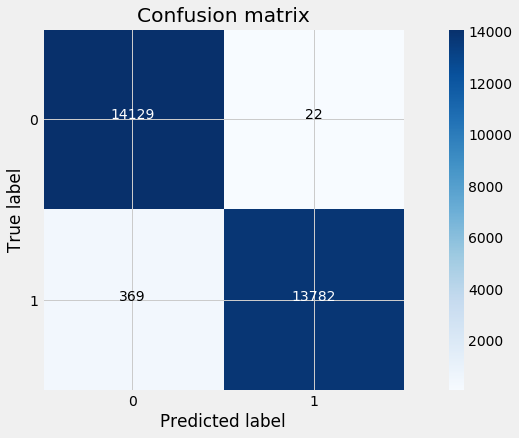

In [44]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
##################################################################################

# Compute confusion matrix
cnf_matrix = confusion_matrix(y, predicted1)  # 生成混淆矩阵
np.set_printoptions(precision=2)

print('Recall metric in the testing dataset: ',cnf_matrix[1,1]/float((cnf_matrix[1,0]+cnf_matrix[1,1])))

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()